In [1]:
import os
import json
import time
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pose_visualisation as vis
import reader, helpers
import torch, torch.nn
import scipy
%matplotlib inline
torch.set_default_dtype(torch.double)

import functools
import scipy.io
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import Adam
from torch.utils.data import DataLoader
import math
#from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
device ='cpu'
import numpy as np
import torch
from torch.autograd.functional import jacobian, hessian
torch.set_default_dtype(torch.double)
from ipynb.fs.defs.gBAOAB import gBAOAB_integrator, gBAOAB_integrator_mass, gBAOAB_step_exact, rattle_step,gBAOAB_integrator_old
from ipywidgets import IntProgress
from IPython.display import display
import time
import random

In [2]:
torch.set_num_threads(2)
torch.get_num_threads()

2

In [3]:
def camera_generator(u, consts):
    """Generate camera parameters from (log-)normal model."""
    if u.dim() ==1:
        u = u.unsqueeze(0).detach()
    cam_foc = torch.ones_like(u[:, 0]) * consts['cam_foc']
    cam_pos = torch.concatenate([
        consts['cam_pos_x_mean'] + consts['cam_pos_x_std'] * u[:, 0:1],
        consts['cam_pos_y_mean'] + consts['cam_pos_y_std'] * u[:, 1:2],
        torch.exp(consts['log_cam_pos_z_mean'] +
               consts['log_cam_pos_z_std'] * u[:, 2:3])
    ], 1)
    cam_ang = torch.ones_like(u[:, :3]) * consts['cam_ang']
    return cam_foc, cam_pos, cam_ang

In [4]:
def camera_matrix_batch(focal_length, position, yaw_pitch_roll):
    """Get projective camera matrix given pose and focal length (batch)."""
    if position.ndim == 2:
        n_batch = position.shape[0]
    else:
        n_batch = 1
        focal_length = focal_length.reshape((1,))
        position = position[None, :]
        yaw_pitch_roll = yaw_pitch_roll[None, :]
    cam_mtx = torch.zeros((n_batch, 3, 4))
    rot_mtx = rot_z_batch(yaw_pitch_roll[:, 2])
    rot_mtx = torch.bmm(
        rot_mtx, rot_x_batch(yaw_pitch_roll[:, 1]))
    rot_mtx = torch.bmm(
        rot_mtx, rot_y_batch(yaw_pitch_roll[:, 0]))
    cam_mtx[:, :, :3]= rot_mtx
    cam_mtx[:, :, 3]= position
    int_mtx = torch.stack([focal_length, focal_length,
                        torch.ones_like(focal_length)])
    cam_mtx = (int_mtx * cam_mtx.T).T
    return cam_mtx


In [5]:
def rot_x(ang):
    """Returns matrix which defines rotation by `ang` about x-axis (0-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        1, 0, 0,
        0, c, -s,
        0, s, c,
    ]).reshape((3, 3))


def rot_y(ang):
    """Returns matrix which defines rotation by `ang` about y-axis (1-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, 0, s,
        0, 1, 0,
        -s, 0, c,
    ]).reshape((3, 3))


def rot_z(ang):
    """Returns matrix which defines rotation by `ang` about z-axis (2-axis)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    return torch.tensor([
        c, -s, 0,
        s, c, 0,
        0, 0, 1,
    ]).reshape((3, 3))


def rot_x_batch(ang):
    """Returns batch of matrices which defines rotations about x-axis (0)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 1, 1]=c
    rot[:, 1, 2]= -s
    rot[:, 2, 1]= s
    rot[:, 2, 2]= c
    return rot


def rot_y_batch(ang):
    """Returns batch of matrices which defines rotations about y-axis (1)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 2]= s
    rot[:, 2, 0]= -s
    rot[:, 2, 2]= c
    return rot


def rot_z_batch(ang):
    """Returns batch of matrices which defines rotations about z-axis (2)."""
    s = torch.sin(ang)
    c = torch.cos(ang)
    rot = torch.eye(3).unsqueeze(0).repeat(ang.shape[0], 1, 1)
    rot[:, 0, 0]= c
    rot[:, 0, 1]= -s
    rot[:, 1, 0]=s
    rot[:, 1, 1]=c
    return rot


rotation_map = {
    'Xrotation': rot_x,
    'Yrotation': rot_y,
    'Zrotation': rot_z
}
rotation_map_batch = {
    'Xrotation': rot_x_batch,
    'Yrotation': rot_y_batch,
    'Zrotation': rot_z_batch
}

In [6]:
consts = {
    'seed': 1234,
    'n_joint': 19,
    'n_joint_angle': 47,
    'n_joint_angle_latent': 30,
    'n_bone_length_input': 13,
    'n_camera_input': 3,
    'output_noise_std': 0.001,
    'cam_foc': np.exp(2.),
    'cam_pos_x_mean': 0.,
    'cam_pos_y_mean': 0.,
    'cam_pos_x_std': 0.1,
    'cam_pos_y_std': 0.1,
    'log_cam_pos_z_mean': 1.5,
    'log_cam_pos_z_std': 0.5,
    'cam_ang': torch.tensor(np.array([np.pi, 0., 0.])),
    'cam_pos_offset': torch.tensor(np.array([0.5, 0., 0.])),
    'cam_ang_offset': torch.tensor(np.array([0.0, 0., 0.]))
}
consts['n_joint_angle_input'] = (
    consts['n_joint_angle_latent'] +
    consts['n_joint_angle'] * 2)

In [7]:
bvh_reader = reader.BvhReader('skeleton.bvh')
bvh_reader.read()
helpers.process_skeleton(bvh_reader.root)
consts['skeleton'] = bvh_reader.root

with open('fixed_angles.json', 'r') as f:
    consts['fixed_joint_angles'] = json.load(f)

In [8]:
with np.load('params.npz') as f:
    l = 1
    #print(f['W_{0}'.format(l)])
    print('W_{0}'.format(l))

W_1


In [9]:
with np.load('params.npz') as f:
    num_layers = 7
    consts['joint_angles_vae_decoder_layers'] = []
    for l in range(num_layers):
        weight = torch.tensor(f['W_{0}'.format(l)])
        bias = torch.tensor(f['b_{0}'.format(l)])

        linear_layer = torch.nn.Linear(weight.size(0), weight.size(1))
        linear_layer.weight.data = weight
        linear_layer.bias.data = bias
        if l != num_layers - 1:
            nonlinearity = torch.nn.Tanh()
        else:
            nonlinearity = torch.nn.Identity()
        consts['joint_angles_vae_decoder_layers'].append({
            'linear_layer': linear_layer,
            'nonlinearity': nonlinearity })

In [10]:
consts['joints_to_skip'] = [
    'hips',
    'leftshoulder',
    'rightshoulder',
    'lefthandthumb1',
    'righthandthumb1',
    'lefthandthumb1endsite',
    'righthandthumb1endsite',
    'lefttoebaseendsite',
    'righttoebaseendsite'
]
lengths_model_params = np.load('params2.npz')
consts['log_lengths_covar'] = torch.tensor(lengths_model_params['covar'])
consts['log_lengths_covar_chol'] = torch.tensor(la.cholesky(lengths_model_params['covar']))
consts['log_lengths_mean'] = torch.tensor(lengths_model_params['mean'])

In [11]:
with open('lengths_order.json', 'r') as f:
    lengths_order = json.load(f)
    consts['bone_lengths_map'] = {
    node_name: lengths_order[length_name]
    for node_name, length_name
    in helpers.bone_lengths_map.items()
    if node_name not in ['lefthandthumb1endsite', 'righthandthumb1endsite']
}

In [12]:
rng = np.random.RandomState(consts['seed'])

In [13]:
n_noise = consts['n_joint'] * 4
n_in_dim = (
    consts['n_camera_input'] +
    consts['n_bone_length_input'] +
    consts['n_joint_angle_input'] +
    4 * consts['n_joint']
)

In [14]:
# this bit does some weird thing where it pre-calls the function, nothing is actually being generated yet since u is just some constant
# u = tt.matrix('u')
# y_bin = pose.noisy_binocular_2d_proj_generator(u, consts)
# y_3d = pose.joint_3d_pos_generator(u, consts)
# generator_binocular = th.function([u], y_bin)
# generator_3d = th.function([u], y_3d)

In [15]:
def partition(inputs, lengths):
    """Partition a one/two-dimesional tensor in to parts along last axis."""
    i = 0
    parts = []
    for l in lengths:
        parts.append(inputs.T[i:i+l].T)
        i += l
    return parts

In [16]:
def bone_lengths_generator(u, consts):
    """Generate skeleton bone lengths from log-normal model."""
    rng.seed(0)
    u_data = torch.tensor(rng.normal(size=u.size()))
    return torch.exp(consts['log_lengths_mean'] +
                  (u_data @ consts['log_lengths_covar_chol']))

def joint_angles_cos_sin_vae_decoder(h, layers, n_joint_angle):
    h = layers[0]['nonlinearity'](
        (h @ layers[0]['linear_layer'].weight.data) + layers[0]['linear_layer'].bias.data)
    # intermediate layers with skip-connections
    for layer in layers[1:-1]:
        h = layer['nonlinearity'](
            (h@layer['linear_layer'].weight.data) + layer['linear_layer'].bias.data) + h
    h = layers[-1]['nonlinearity'](
    (h@layers[-1]['linear_layer'].weight.data) + layers[-1]['linear_layer'].bias.data)
    if h.dim() == 1:
        h =h.unsqueeze(0).detach()
    return h[:, :n_joint_angle * 2], torch.exp(0.5 * h[:, n_joint_angle * 2:])


def joint_angles_generator(u, consts):
    """Generate joint angles from VAE decoder model."""
    h, n = partition(u, [consts['n_joint_angle_latent'],
                         consts['n_joint_angle'] * 2])
    ang_cos_sin_mean, ang_cos_sin_std = joint_angles_cos_sin_vae_decoder(
        h, consts['joint_angles_vae_decoder_layers'], consts['n_joint_angle'])
    ang_cos_sin = ang_cos_sin_mean + ang_cos_sin_std * n
    return torch.arctan2(ang_cos_sin[:, consts['n_joint_angle']:],
                      ang_cos_sin[:, :consts['n_joint_angle']])

In [17]:
def joint_positions(node, angles, fixed_angles=None, lengths=None,
                    lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles."""
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4)
    joints = []
    rot = torch.eye(3)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = (rot@rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = (rot@ rotation_map[ch](torch.tensor(angles[i[0]])))
                i[0] += 1
    local_trans = torch.eye(4)
    local_trans[:3, :3] = rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = torch.tensor(np.array(node.offset))
        else:
            length = lengths[lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit) * length)
        local_trans[:3, 3] = torhc.tensor(node_offset)
        node_trans = parent_trans.dot(local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, 3])
        for child in node.children:
            joints += joint_positions(child, angles, fixed_angles, lengths,
                                      lengths_map, skip, i, node_trans)
    return joints

In [18]:
def joint_positions_batch(
        node, angles, fixed_angles=None, lengths=None,
        lengths_map=None, skip=[], i=None, parent_trans=None):
    """Get list of joint pos. given skeleton tree and joint angles (batch)."""
    # check whether single vector of angles or mini-batch matrix provided
    if angles.ndim == 2:
        n_batch = angles.shape[0]
    elif angles.ndim == 1:
        n_batch = 1
        angles = angles[None, :]
        if lengths is not None and lengths.ndim == 1:
            lengths = lengths[None, :]
    else:
        raise Exception('angles should be one or two dimensional.')
    if i is None:
        i = [0]
    if parent_trans is None:
        parent_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    joints = []
    rot = torch.eye(3).unsqueeze(0).repeat(n_batch, 1, 1)
    for ch in node.channels:
        ch_key = node.name.lower() + '_' + ch[0].lower()
        if ch in rotation_map:
            if fixed_angles is not None and ch_key in fixed_angles:
                rot = rot@(rotation_map[ch](torch.tensor(fixed_angles[ch_key])))
            else:
                rot = torch.bmm(
                    rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
                i[0] += 1
    local_trans = torch.eye(4).unsqueeze(0).repeat(n_batch, 1, 1)
    local_trans[:, :3, :3] =  rot
    if not (node.name.lower() in skip and node.is_end_site):
        if lengths is None or node.length == 0.:
            node_offset = np.array(node.offset)[None, :]
        else:
            if lengths.dim() == 1:
                lengths = lengths.unsqueeze(0).detach()
            length = lengths[:, lengths_map[node.name.lower()]]
            node_offset = (torch.tensor(node.offset_unit[None, :]) *
                           length[:, None])
        local_trans[:, :3, 3]= torch.tensor(node_offset)
        node_trans = torch.bmm(parent_trans, local_trans)
        if not node.name.lower() in skip:
            joints.append(node_trans[:, :, 3])
        for child in node.children:
            joints += joint_positions_batch(
                child, angles, fixed_angles, lengths,
                lengths_map, skip, i, node_trans)
    return joints


In [19]:
def joint_3d_pos_generator(u, consts):
    """Generate 3D joint positions.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system.
    """
    input_sizes = [consts['n_bone_length_input'],
                   consts['n_joint_angle_input']]
    u_len, u_ang = partition(u, input_sizes)
    bone_lengths = bone_lengths_generator(u_len, consts)
    joint_angles = joint_angles_generator(u_ang, consts)
    return torch.stack(joint_positions_batch(
        consts['skeleton'], joint_angles, consts['fixed_joint_angles'],
        lengths=bone_lengths, lengths_map=consts['bone_lengths_map'],
        skip=consts['joints_to_skip']), 2)

In [20]:
def binocular_2d_proj_generator(u, consts):
    """Generate binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models.
    """
    n_batch = 1
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'],
                   consts['n_camera_input']]
    u_ske, u_cam, = partition(u, input_sizes)
    joint_pos_3d = joint_3d_pos_generator(u_ske, consts)
    cam_foc, cam_pos, cam_ang = camera_generator(u_cam, consts)
    cam_mtx_1 = camera_matrix_batch(
        cam_foc, cam_pos + consts['cam_pos_offset'],
        cam_ang + consts['cam_ang_offset'])
    cam_mtx_2 = camera_matrix_batch(
        cam_foc, cam_pos - consts['cam_pos_offset'],
        cam_ang - consts['cam_ang_offset'])
    joint_pos_2d_hom_1 = torch.bmm(cam_mtx_1, joint_pos_3d)
    joint_pos_2d_1 = (joint_pos_2d_hom_1[:, :2] /
                      joint_pos_2d_hom_1[:, 2][:, None, :])
    joint_pos_2d_hom_2 = torch.bmm(cam_mtx_2, joint_pos_3d)
    joint_pos_2d_2 = (joint_pos_2d_hom_2[:, :2] /
                      joint_pos_2d_hom_2[:, 2][:, None, :])

    return torch.concatenate(
               [joint_pos_2d_1.reshape((n_batch, -1)),
                joint_pos_2d_2.reshape((n_batch, -1))], 1)



In [21]:
def noisy_binocular_2d_proj_generator(u, consts):
    """Generate noisy binocular 2D joint position projections.

    Generates bone lengths and joint angles from respective models then uses
    skeleton definition to convert to 3D joint positions in global coordinate
    system, before projecting to two sets of 2D image coordinates using two
    offset generated camera models and adding Gaussian observation noise to
    projections.
    """
    input_sizes = [consts['n_bone_length_input'] +
                   consts['n_joint_angle_input'] +
                   consts['n_camera_input'],
                   consts['n_joint'] * 4]
    u_pos, u_noi = partition(u, input_sizes)
    return (binocular_2d_proj_generator(u_pos, consts) +
            consts['output_noise_std'] * u_noi)

## "Observed" Data

In [22]:
n_data = 1
rng.seed(consts['seed'])
u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
y_data = noisy_binocular_2d_proj_generator(u_data, consts)
y_data_3d = joint_3d_pos_generator(u_data, consts)
np.savez('observed-data.npz',u_data=u_data, y_data=y_data, y_data_3d=y_data_3d)

C:\Users\Tadgh\AppData\Local\Temp\ipykernel_23288\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_23288\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_23288\959262985.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Tri

In [23]:
y_data_3d[:,0:3,:].squeeze().size()

torch.Size([3, 19])

## Generating a ton of these

In [24]:
transform = torch.zeros((19,3))
for i in range(19):
    transform[i][2] = 2
transform = transform.unsqueeze(0)

In [26]:
train_dataset = []
for i in range(100000):
    print(i)
    n_data = 1
    rng.seed(i)
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T.unsqueeze(0)
    train_dataset.append(points_3d+ transform - points_3d[0][0])

0
1


C:\Users\Tadgh\AppData\Local\Temp\ipykernel_23288\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_23288\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

KeyboardInterrupt: 

In [26]:
test_dataset = []
for i in range(1000,1101):
    n_data = 1
    rng.seed(i)
    u_data = torch.tensor(rng.normal(size=(n_data, n_in_dim)))
    y_data = noisy_binocular_2d_proj_generator(u_data, consts)
    y_data_3d = joint_3d_pos_generator(u_data, consts)
    points_3d = y_data_3d[:,0:3,:].squeeze().T.unsqueeze(0)
    test_dataset.append(points_3d+transform- points_3d[0][0])

C:\Users\Tadgh\AppData\Local\Temp\ipykernel_13988\795312297.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rot, rotation_map_batch[ch](torch.tensor(angles[:, i[0]])))
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_13988\795312297.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  local_trans[:, :3, 3]= torch.tensor(node_offset)


In [27]:
train_dataset = np.array(train_dataset[:40000])
np.save('train_dataset.npy',train_dataset)
train_dataset = [torch.tensor(x) for x in train_dataset]

In [44]:
test_dataset = np.array(test_dataset)
np.save('test_dataset.npy',test_dataset)
test_dataset = [torch.tensor(x)  for x in test_dataset]

In [45]:
# train_dataset = np.array(train_dataset)
# np.save('train_dataset.npy', test_dataset)

In [46]:
ts = np.array([td[:,:,2].numpy() for td in test_dataset])

In [47]:
ts.min()

0.8366985058712301

In [48]:
j3d33 = y_data_3d[:,0:3,:].squeeze().T

(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

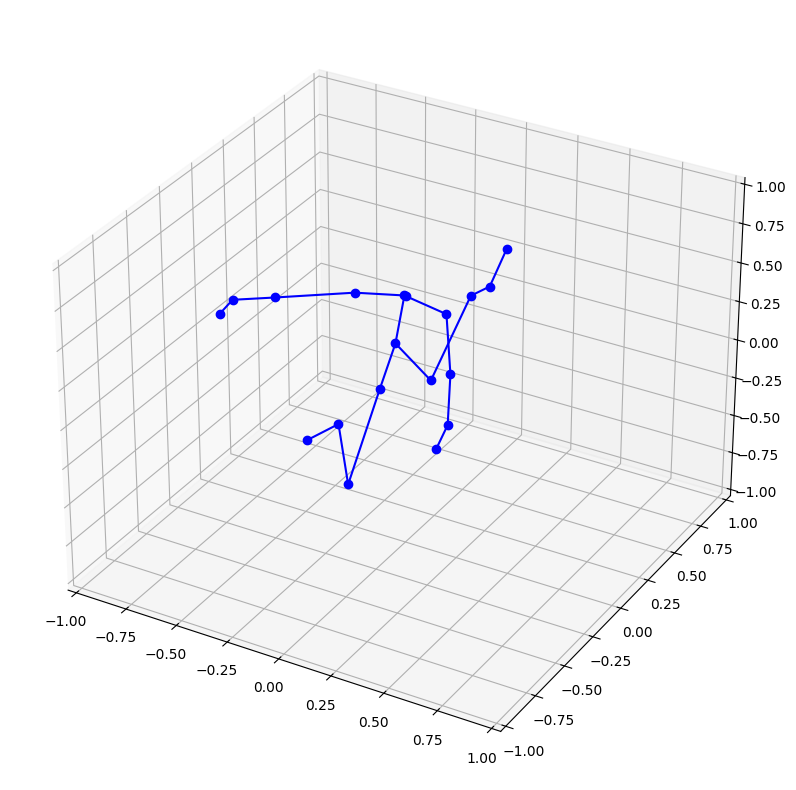

In [49]:
vis.plot_3d_pose(j3d33)

## PCA

In [50]:
train_data = np.array([d.numpy() for d in train_dataset])
test_data = np.array([d.numpy() for d in test_dataset])

In [51]:
list = np.transpose(np.array([data[0].flatten().numpy() for data in train_dataset]))

# Demean each row
mean_row = np.mean(list, axis=1, keepdims=True)
list = list - mean_row

In [52]:
np.shape(list)

(57, 1000)

In [53]:
U, S,_=np.linalg.svd(list)

In [54]:
eigenposes = np.transpose(U)
eigenvalues = S**2

In [55]:
np.save('eigenposes.npy', eigenposes)
np.save('eigenvals.npy', eigenvalues)

In [56]:
eigenposes = np.array([eigenpose + np.squeeze(mean_row) for eigenpose in eigenposes])

AttributeError: 'XTick' object has no attribute 'label'

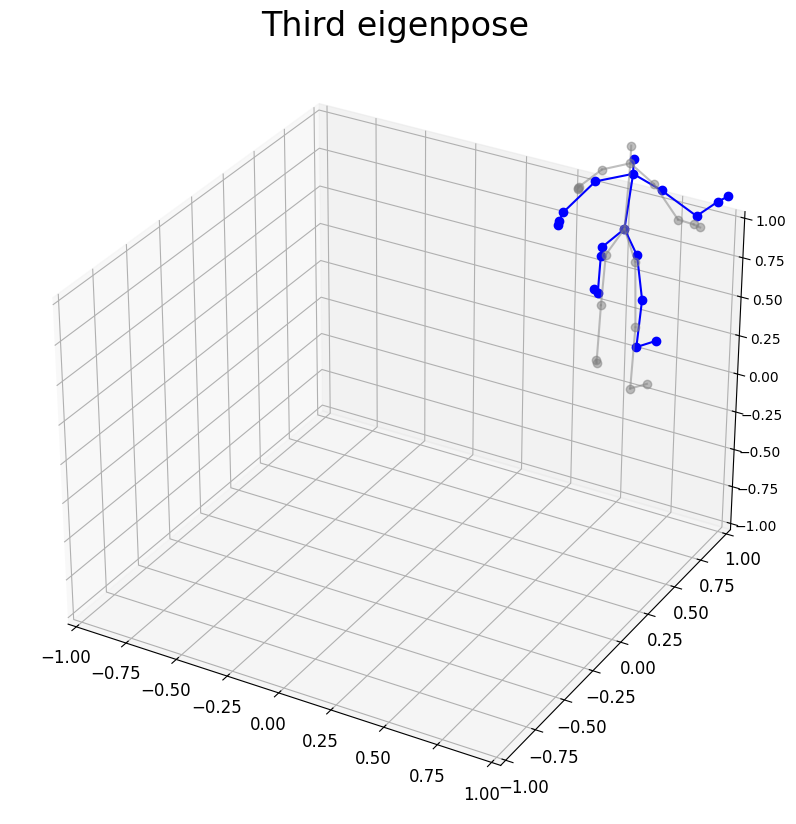

In [57]:
ep0 = (eigenposes[1]).reshape((19, 3))
ep1 = (np.squeeze(mean_row)).reshape((19, 3))
t3 = np.zeros_like(ep0)
t3[:,2] = np.ones_like(t3[:,1])
fig, ax =vis.add_3d_pose([ep0, ep1], alphas =[1,0.5], labels = ["Third eigenpose","Mean pose"])

ax.set_title('Third eigenpose', fontsize = 24)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(12)
plt.legend()

In [58]:
eigenvalues = eigenvalues[:-3]
eigenposes = eigenposes[:-3]

In [59]:
eigenvalues

array([7.88056961e+02, 6.32130506e+02, 4.69738877e+02, 3.85562466e+02,
       3.65428099e+02, 3.06751727e+02, 2.08316128e+02, 1.97204512e+02,
       1.38884562e+02, 1.29126324e+02, 1.06360158e+02, 9.32613346e+01,
       3.92877071e+01, 2.78272502e+01, 2.10547179e+01, 1.59209179e+01,
       1.36153070e+01, 1.24962451e+01, 9.45655027e+00, 8.22287020e+00,
       7.34896411e+00, 6.35542421e+00, 5.55866368e+00, 4.81430300e+00,
       4.43357386e+00, 3.09550185e+00, 2.53239035e+00, 2.17736697e+00,
       1.89564815e+00, 1.75523732e+00, 1.63031087e+00, 1.45950264e+00,
       1.38076141e+00, 1.14626179e+00, 1.04074078e+00, 8.87130007e-01,
       8.72619430e-01, 8.54113944e-01, 7.20381209e-01, 6.94689393e-01,
       5.70729994e-01, 4.96790494e-01, 3.94471409e-01, 3.33781093e-01,
       2.70191945e-01, 2.58495545e-01, 2.22573429e-01, 2.10025128e-01,
       1.92604888e-01, 1.84307365e-01, 1.65959047e-01, 1.49712743e-01,
       1.39132737e-01, 1.28570941e-01])

In [60]:
# getting the average pose
avg_pose = np.squeeze(train_data.mean(axis=0))
avg_pose = np.ndarray.flatten(avg_pose)
avg_pose.reshape(19, 3)

array([[ 0.00000000e+00,  0.00000000e+00,  2.00000000e+00],
       [ 5.60798411e-03,  4.30691917e-01,  2.02860036e+00],
       [ 2.11933405e-03,  5.42526481e-01,  2.03912095e+00],
       [ 1.39597552e-01,  3.47843602e-01,  2.00606499e+00],
       [ 2.58208459e-01,  1.39114099e-01,  2.02212813e+00],
       [ 2.89376611e-01,  5.66661851e-02,  2.12307303e+00],
       [ 3.07329410e-01,  2.31538434e-02,  2.15488177e+00],
       [-1.17311665e-01,  3.71058953e-01,  1.98799146e+00],
       [-2.23632124e-01,  2.28407347e-01,  1.96992321e+00],
       [-2.62359780e-01,  1.69236981e-01,  2.03763091e+00],
       [-2.76428439e-01,  1.44914888e-01,  2.06301883e+00],
       [ 7.11850014e-02, -1.89211740e-01,  1.97857691e+00],
       [ 8.08995526e-02, -6.41044961e-01,  1.98111096e+00],
       [ 8.66353895e-02, -1.04204139e+00,  1.93524345e+00],
       [ 1.11390781e-01, -1.08027911e+00,  2.05842393e+00],
       [-7.42725771e-02, -1.81675165e-01,  1.96574947e+00],
       [-1.09698292e-01, -5.67889425e-01

Saving these

In [61]:
np.save('avg_pose.npy',avg_pose)
np.save('eigenposes.npy',eigenposes)
np.save('eigenvals.npy',eigenvalues)

In [ ]:
def length_constraint(i,j, init):
    def constraint_fn(x):
        return (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2 - ((init[3*i]- init[3*j])**2 +(init[3*i+1]- init[3*j+1])**2 + (init[3*i+2]- init[3*j+2])**2)
    return constraint_fn

In [ ]:
i = 0
j=1

In [ ]:
x_init = train_dataset[0]
lengths = []
for n in range(50):
    x = torch.flatten(train_dataset[n][0])
    l = (x[3*i]- x[3*j])**2 +(x[3*i+1]- x[3*j+1])**2 + (x[3*i+2]- x[3*j+2])**2
    lengths.append(l)

In [ ]:
plt.plot(lengths)

In [ ]:
def avg_j2j(frame1,frame2):
    dists = []
    frame_1 = np.array(frame1)
    frame_2 = np.array(frame2)
    for i in range(len(frame1)):
        d = math.dist(frame_1[i], frame_2[i])
        dists.append(d)
    return np.mean(dists)

In [ ]:
# taking the list of bones from pose_visualisation for the constraints
bones = [
    (0, 1),
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]
bones2 = [
    (1, 2),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (11, 12),
    (12, 13),
    (13, 14),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [ ]:
def length_constraint_2(i, init):
    def constraint_fn(x):
        return (x[3*i]- 0)**2 +(x[3*i+1]- 0)**2 + (x[3*i+2]- 1)**2 - ((init[3*i]- 0)**2 +(init[3*i+1]- 0)**2 + (init[3*i+2]- 1)**2)
    return constraint_fn

In [ ]:
def median(positions):
    dist = 1000
    median = positions[0].detach().reshape((19,3))
    for position in positions:
        dis = 0
        for pos2 in positions:
            dis += torch.linalg.norm(position.detach() - pos2.detach())
        if dis< dist:
            dist = dis
            median = position.detach().reshape((19,3))
    return median

In [ ]:
x_init

In [ ]:
def lengths(bones,poses):
    lengths = []
    poses = torch.squeeze(poses).reshape((19,3))
    for bone in bones:
        l = poses[bone[0]] -poses[bone[1]]
        l = torch.sqrt(torch.dot(l,l))
        lengths.append(l)
    return lengths

In [ ]:
def joints_to_angles(pose, bones, lengths):
    ps = pose.reshape((19,3))
    angs = []
    for i in range(len(bones)):
        bone = bones[i]
        r = lengths[i]
        joint1 = ps[bone[0]]
        joint2 = ps[bone[1]]
        x = joint2[0] - joint1[0]
        y = joint2[1] -joint1[1]
        z = joint2[2] -joint1[2]
        phi = torch.sign(y) * torch.arccos(x/torch.sqrt(x**2 + y**2))
        theta = torch.arccos(z/r)
        angs.append([phi,theta])
    return torch.tensor(angs)

In [ ]:
def angles_to_joints(angles, lengths,bones):
    pose = torch.zeros((19,3))
    pose[0] = torch.tensor([0,0,2])
    for i in range(len(bones)):
        bone = bones[i]
        r = lengths[i]
        phi = torch.tensor(angles[i][0])
        theta = torch.tensor(angles[i][1])
        pose[bone[1]] = pose[bone[0]] + torch.tensor([r*torch.sin(theta)*torch.cos(phi),r*torch.sin(theta)*torch.sin(phi),r*torch.cos(theta)])
    return pose

In [ ]:
a = joints_to_angles(x_init, bones, lengths(bones, x_init))

In [ ]:
j = angles_to_joints(a, lengths(bones, x_init), bones)

In [ ]:
x = test_dataset[3]
a = joints_to_angles(x, bones, lengths(bones, x))
j = angles_to_joints(a, lengths(bones, x), bones)

In [ ]:
x

In [ ]:
j

In [167]:
def average_angle_position(positions, bones):
    angs = []
    for position in positions:
        pose = position.detach().reshape((19,3))
        a = joints_to_angles(pose, bones, lengths(bones, pose))
        angs.append(a)
    angs = np.array(angs)
    print(f"Angs = {np.shape(angs)}")
    avg_angles = angs.mean(axis = 0)
    mean_p = angles_to_joints(avg_angles, lengths(bones, pose), bones)
    return mean_p

In [172]:
h = .01
consts = []
const_densities = []
meds = []
med_densities =[]
means = []
std = 0.3
f = IntProgress(min=0, max=len(test_dataset[0:10]))
display(f)
i = 0
for frame1 in test_dataset[0:100]:
    t = time.time()
    print(f"Frame {i}")
    i +=1
    frame = torch.squeeze(frame1)

    M = torch.eye(19*3)


    # initialising from a random training pose
    x_init = torch.flatten(train_dataset[random.randint(0,99)])
    v_init = torch.zeros_like(x_init)
    x_init.requires_grad =True

    gs = [length_constraint(i,j,x_init) for (i,j) in bones2]
    gs.append(length_constraint_2(1,x_init))
    gs.append(length_constraint_2(11,x_init))
    gs.append(length_constraint_2(15,x_init))

    # defining and randomly perturbing the image
    fx = 1.0
    fy = 1.0
    cx = 0
    cy = 0
    a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
    a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
    a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)
    i1 = frame @ a1
    i2 = frame @ a2
    i3 = frame @ a3

    image = torch.hstack([i1/i3, i2/i3])


    image += torch.randn_like(image) * std

    # need to re-define density, force and mass to use the new image
    def neg_log_density(pose2):
        pose = pose2.reshape((19,3))
        pose = torch.squeeze(pose)
        fx = 1.0
        fy = 1.0
        cx = 0
        cy = 0
        a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
        a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
        a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)

        # Map the 3D point to 2D point
        p1 = pose@ a1
        p2 = pose @ a2
        p3 = pose @ a3

        projection = torch.hstack([p1/p3, p2/p3])
        #print(projection)
        #print(image)
        n = projection - image
        #print(n)
        # note - taking the variance to be 1...
        pi = torch.tensor([0.], requires_grad=True)
        for point in n[1:]:
            pi = pi+ (torch.dot(point,point)) / (std**2)

        p2 = torch.flatten(pose)
        for i in range(len(eigenvalues)):
            pi = pi+ (torch.dot(torch.tensor(eigenposes[i])[3:],(p2-torch.tensor(avg_pose))[3:])**2 / eigenvalues[i])
        return pi

    def force(x):
        return torch.squeeze(jacobian(neg_log_density, x), dim = 0)


    positions,_ = gBAOAB_integrator(x_init,v_init,force, gs, h,M, 1, 1, 9,3, 10**(-10))


    # getting the median position
    med = median(positions[1:])
    med[0] = torch.zeros_like(med[0])
    med[0][-1] = 2
    median_avg = avg_j2j(med.reshape((19,3)),frame)
    meds.append(median_avg)
    med_densities.append(neg_log_density(med))
    # BFGS
    print(f"Average joint movement: {avg_j2j(med.reshape((19,3)),x_init.detach().reshape((19,3)))}")


    edited_positions = [posit.detach().reshape((19,3)) for posit in positions]
    epos = []
    for epo in edited_positions:
        ep = epo
        ep[0] = torch.zeros_like(ep[0])
        ep[0][-1] = 2
        epos.append(epo)
    mean_angle = average_angle_position(epos, bones).reshape((19,3))
    mean_angle[0] = torch.zeros_like(mean_angle[0])
    mean_angle[0][-1] =2
    mean_avg = avg_j2j(mean_angle,frame)
    means.append(mean_avg)

    # convering to numpy and re-defining the constraints.
    x_init = np.ndarray.flatten(x_init.detach().numpy())
    image = image.numpy()

    gs = [length_constraint(i, j, x_init) for (i, j) in bones2]
    gs.append(length_constraint_2(1, x_init))
    gs.append(length_constraint_2(11, x_init))
    gs.append(length_constraint_2(15, x_init))

    constraints = [{'type': 'eq', 'fun': fn} for fn in gs]


    def neg_log_density(pose2):
        pose = pose2.reshape((19, 3))
        pose = np.squeeze(pose)
        fx = 1.0
        fy = 1.0
        cx = 0
        cy = 0
        a1 = np.array([[fx], [0], [cx]])
        a2 = np.array([[0], [fy], [cy]])
        a3 = np.array([[0], [0], [1]])

        # Map the 3D point to 2D point
        p1 = pose @ a1
        p2 = pose @ a2
        p3 = pose @ a3

        projection = np.hstack([p1 / p3, p2 / p3])
        #print(projection)
        #print(image)
        n = projection - image
        #print(n)
        # note - taking the variance to be 1...
        pi = 0
        for point in n[1:]:
            pi = pi + (np.dot(point, point)) / (std**2)

        p2 = np.ndarray.flatten(pose)
        for i in range(len(eigenvalues)):
            pi = pi + (np.dot(eigenposes[i][3:], (p2 - avg_pose)[3:]) ** 2 / eigenvalues[i])
        return pi


    res = scipy.optimize.minimize(neg_log_density, x0=x_init, method='SLSQP',constraints=constraints, options={'maxiter': 200})
    const_x = res.x.reshape((19,3))
    const_x[0] = np.zeros_like(med[0])
    const_x[0][-1] = 2
    if res.success == False:
        print("DID NOT CONVERGE~")
    const_avg = avg_j2j(const_x, frame.numpy())
    consts.append(const_avg)
    print(f"Consts = {consts}")
    print(f"Meds = {meds}")
    print(f"Means = {means}")
    const_densities.append(neg_log_density(res.x))
    t2 = time.time()
    print(f"Time elapsed: {t2-t}")

IntProgress(value=0, max=10)

Frame 0
STEP 0
G1 = <function G.<locals>.G_gs at 0x00000256D4605630>
M1 = tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
G1 = <function G.<locals>.G_gs at 0x00000256D4605630>
M1 = tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
G1 = <function G.<locals>.G_gs at 0x00000256D4605630>
M1 = tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
G1 = <function G.<locals>.G_gs at 0x00000256D4


KeyboardInterrupt



In [ ]:
positions[-1]

In [ ]:
dens = [neg_log_density(pos).detach() for pos in positions]

In [ ]:
plt.plot(dens)

In [ ]:
mean_angle = average_angle_position(epos[200:], bones).reshape((19,3))
mean_angle[0] = torch.zeros_like(mean_angle[0])
mean_angle[0][-1] =2
avg_j2j(mean_angle,frame)


In [ ]:
res

In [ ]:
med = median(positions[200:])
med[0] = torch.zeros_like(med[0])
med[0][-1] = 2
avg_j2j(med.reshape((19,3)),frame)

In [ ]:
plt.plot(consts, label = 'consts')
plt.plot(meds, label = 'medians')
plt.legend()

In [ ]:
res

In [ ]:
# checking that constraints are satisfied
pp = positions[-1].reshape((19,3))
length_constraint_2(11,x_init)(np.ndarray.flatten(pp.detach().numpy()))

In [ ]:
transform = torch.ones_like(med)*0.5

In [ ]:
vis.plot_3d_pose(pp.detach()-transform)
plt.title(f"Median Pose")
plt.savefig(f"median_pose.pdf")

In [ ]:
mean_angle

In [ ]:
vis.plot_3d_pose(mean_angle-transform)
plt.title(f"Median Pose")
plt.savefig(f"median_pose.pdf")

In [ ]:
vis.plot_3d_pose(constr_x-transform.numpy())
plt.title(f"constrained optimization")
plt.savefig(f"pose_constr_opt.pdf")

In [ ]:
target_pose = test_dataset[2].reshape((19, 3))

In [ ]:
vis.plot_3d_pose(target_pose- transform)
plt.title(f"target pose")
plt.savefig(f"pose_target.pdf")

In [ ]:
final_pose =positions[-1].detach().reshape((19,3))

In [ ]:
mean = torch.stack(positions).detach().mean(axis=0).reshape((19,3))

In [ ]:
vis.plot_3d_pose(mean- transform)
plt.title(f"mean pose")
plt.savefig(f"pose_mean.pdf")

In [ ]:
image

In [ ]:
plt.scatter(image[:,0], image[:,1])

In [ ]:
fx = 1.0
fy = 1.0
cx = 0
cy = 0
a1 = torch.tensor([[fx], [0], [cx]], dtype=torch.double)
a2 = torch.tensor([[0], [fy], [cy]], dtype=torch.double)
a3 = torch.tensor([[0],[0],[1]], dtype=torch.double)

# Map the 3D point to 2D point
p1 = mean@ a1
p2 = mean @ a2
p3 = mean @ a3

projection = torch.hstack([p1/p3, p2/p3])

In [ ]:
plt.scatter(projection[:,0],projection[:,1])

In [ ]:
densities = [d.detach() for d in densities]

In [ ]:
plt.plot(densities)

In [ ]:
print(eigenvalues)

In [ ]:
x_init= test_dataset[0]
t = torch.ones_like(x_init)*0.01

In [ ]:
print(neg_log_density(x_init))

In [ ]:
print(neg_log_density(x_init+t))

In [ ]:
errors = []
for i in range(len(positions)):
    mean_to_i = positions[:i]
    rmse = ((mean - torch.flatten(frame))**2).mean()**0.5
    errors.append(rmse)

In [ ]:
i=0
j=1

In [ ]:
for n in range(len(positions)):
    x = positions[n]
    l = (x[3 * i] - x[3 * j]) ** 2 + (x[3 * i + 1] - x[3 * j + 1]) ** 2 + (x[3 * i + 2] - x[3 * j + 2]) ** 2
    lengths.append(l)
plt.plot(lengths)

In [ ]:
def force(x):
    return torch.zeros_like(x)

In [ ]:
bones2 = [
    (0, 1),
    (1, 3),
    (3, 4),
    (4, 5),
    (5, 6),
    (1, 7),
    (7, 8),
    (8, 9),
    (9, 10),
    (0, 11),
    (11, 12),
    (12, 13),
    (13, 14),
    (0, 15),
    (15, 16),
    (16, 17),
    (17, 18),
]

In [ ]:
def noising_process(pose,p, its, h):
    gs = [length_constraint(i,j,x_init) for (i,j) in bones]
    M = torch.eye(len(pose))
    qs, ps = gBAOAB_integrator_old(pose,p,force, gs, h,M, 1, 1, its)
    return qs[-1], ps[-1]

In [ ]:
q0 = torch.flatten(test_dataset[0])
#q1, v1 = noising_process(q0,torch.zeros_like(q0), 1,0.01)

In [ ]:
q2,v2 = noising_process(q1,v1,9,0.01)
q3,v3 = noising_process(q2,v2,10,0.01)

In [ ]:
pose0 = q0.reshape((19,3))
pose1 = q1.detach().reshape((19,3))
pose2 = q2.detach().reshape((19,3))
pose3 = q3.detach().reshape((19,3))

In [ ]:
t2 = torch.zeros_like(pose0)
t2[2] = 1

In [ ]:
q0 = torch.flatten(test_dataset[0])
pose0 = q0.reshape((19,3))

In [ ]:
transform = torch.ones_like(pose0)/2
fig, ax = vis.plot_3d_pose(pose0- transform)
ax.plot((pose0-transform)[0][0],(pose0-transform)[0][2],(pose0-transform)[0][1],'o', color = 'red')
ax.set_title('t=0')
plt.savefig('t_0.pdf')

In [ ]:
pose0[2]

In [ ]:
(pose1-transform)[2][1]

In [ ]:
fig, ax =vis.plot_3d_pose(pose1- transform)
#ax.plot(x,(pose1-transform)[2][2],(pose1-transform)[2][1],'o', color = 'red')
ax.set_title('t=0.01')
plt.savefig('t_001.pdf')

In [ ]:
fig, ax =vis.plot_3d_pose(pose2- transform)
ax.plot((pose2-transform)[2][0],(pose2-transform)[2][2],(pose2-transform)[2][1],'o', color = 'red')
ax.set_title('t=0.1')
plt.savefig('t_01.pdf')

In [ ]:
fig, ax =vis.plot_3d_pose(pose3- transform)
ax.plot((pose3-transform)[2][0],(pose3-transform)[2][2],(pose3-transform)[2][1],'o', color = 'red')
ax.set_title('t=0.2')
plt.savefig('t_02.pdf')

In [ ]:
vis.plot_3d_pose(pose3- transform)
plt.title("t = .14")
plt.savefig('t_14.pdf')

## Geodesic Random Walk